# Simulação

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.gcpUtils.auth import getCredentials
from src.gcpUtils.bigQuery import pandasToBq, tableToPandas
from src.gcpUtils.google_storage_manager import *

cred = getCredentials("../bd/planejamento-animale-292719-296d49ccdea6.json")

# arquivo de distâncias
ARQUIVO_DISTANCIAS = '../dados/distancias_todas_combinacoes_BIDIRECIONAL.csv'

# constantes do frete
K = 10 * (1/4000)
K_prime = 5 * (1/4000)

# constantes do leadtime
C = 0.006

# fator de preferencia
alpha = 2

ARQUIVO_JSON_FILIAIS = '../dados/filiais_inferior_30.json'
DATA_ANALISE = '2025-08-10'  # Formato AAAA-MM-DD
TABELA_BIGQUERY = 'planejamento-animale-292719.checklists_rollout.ANIMALE_checklist'
PATH_CREDENCAIS = '../bd/planejamento-animale-292719-296d49ccdea6.json'


In [2]:

try:
    print(f"Carregando filiais do arquivo: {ARQUIVO_JSON_FILIAIS}...")
    
    with open(ARQUIVO_JSON_FILIAIS, 'r', encoding='utf-8') as f:
        dados_filiais = json.load(f)
        
    df_filiais = pd.DataFrame(dados_filiais)
    
    lista_nomes_filiais = df_filiais['FILIAL'].unique().tolist()
    
    if not lista_nomes_filiais:
        print("Atenção: Nenhuma filial foi encontrada no arquivo JSON.")
    else:
        print(f"Sucesso. {len(lista_nomes_filiais)} filiais únicas encontradas.")

except FileNotFoundError:
    print(f"Erro: Arquivo JSON não encontrado em '{ARQUIVO_JSON_FILIAIS}'")
    lista_nomes_filiais = []
except Exception as e:
    print(f"Erro ao ler o arquivo JSON: {e}")
    lista_nomes_filiais = []

# --- Montar e Executar a Query ---

if lista_nomes_filiais:
    
    # Ex: Transforma ['Filial A', 'Filial B'] em "('Filial A', 'Filial B')"
    filiais_para_query = "','".join(lista_nomes_filiais)
    filiais_para_query = f"('{filiais_para_query}')"

    query = f"""
        SELECT SKU, FILIAL, VELOCIDADE_VENDA, ALVO, PRESENTE, TRANSITO, 
        EST_TOTAL, CONT_RUPTURA, CONT_FALTA, CONT_EXCESSO, VOLUME_EXCESSO, REGULADOR, EST_DISP, LEADTIME
        FROM {TABELA_BIGQUERY}
        WHERE FILIAL IN {filiais_para_query}
        AND DATA = '{DATA_ANALISE}'
    """
    try:
        # --- Buscar os dados ---
        
        print("Executando consulta no BigQuery...")
        df_resultado = tableToPandas(query, 'planejamento-animale-292719', cred)
        
        print("\n--- Resultado da Consulta ---")
        if df_resultado.empty:
            print("A consulta não retornou dados.")
        else:
            print(df_resultado)

    except Exception as e:
        print(f"\nErro ao executar a consulta no BigQuery: {e}")

else:
    print("\nAnálise não executada pois nenhuma filial foi carregada.")

Carregando filiais do arquivo: ../dados/filiais_inferior_30.json...
Sucesso. 62 filiais únicas encontradas.
Executando consulta no BigQuery...

--- Resultado da Consulta ---
                          SKU                     FILIAL  VELOCIDADE_VENDA  \
0       27.03.1447-1511-TAM_1      ANIMALE ALPHAVILLE CM               0.0   
1       27.03.1448-1511-TAM_1      ANIMALE ALPHAVILLE CM               0.0   
2       27.03.1447-1511-TAM_1         ANIMALE ARACAJU CM               0.0   
3       52.13.5867-0005-TAM_2         ANIMALE ARACAJU CM               0.0   
4       52.13.5867-0005-TAM_2  ANIMALE BALNEARIO SHOP CM               0.0   
...                       ...                        ...               ...   
96014  52.13.6094-10058-TAM_2                  BUZIOS CM               0.0   
96015  52.13.6094-10058-TAM_3                  BUZIOS CM               0.0   
96016   52.13.6307-0005-TAM_2                  BUZIOS CM               0.0   
96017   52.13.6379-0005-TAM_4                 

# Simução de passagem dos dias

### Novos parâmetros dos SKU's:
- 1) DISPONIVEL: estoque presente na loja
- 2) TRANSITO: sob o processo de entrega
- 3) ESTOQUE_TOTAL = DISPONIVEL + TRANSITO
- 4) CONT_RUPTURA: produto em estado de ruptura
- 5) VELOCIDADE_VENDA: "fração" de produtos a serem vendidos naquele dia. Quando a velocidade_venda de venda soma 1, há a venda de um produto.
- 6) CONT_EXCESSO: produto em estado de excesso
- 7) VOLUME_EXCESSO: quantidade em execesso
- 8) REGULADOR: quantidade de produtos no centro de distribuição 
- 9) DATA: data daquele registro



In [ ]:
from datetime import datetime, timedelta
import math

def carregar_matriz_distancia(caminho_csv):
    """
    Carrega o CSV de distâncias, selecionando apenas as colunas necessárias.
    Retorna um DataFrame vazio em caso de erro.
    """
    colunas_necessarias = ['Filial_A', 'Filial_B', 'Distancia_km']
    try:
        df_dist = pd.read_csv(
            caminho_csv,
            usecols=colunas_necessarias
        )
        print(f"Matriz de distâncias carregada com {len(df_dist)} combinações.")
        return df_dist
    except FileNotFoundError:
        print(f"Erro: Arquivo CSV não encontrado em '{caminho_csv}'")
        return pd.DataFrame(columns=colunas_necessarias)
    except ValueError as e:
        print(f"Erro ao carregar CSV (verifique as colunas): {e}")
        return pd.DataFrame(columns=colunas_necessarias)
    except Exception as e:
        print(f"Erro inesperado ao carregar CSV: {e}")
        return pd.DataFrame(columns=colunas_necessarias)

def _identificar_fontes_destinos(df_estoque):
    # Fontes (excesso > 0)
    df_fontes = df_estoque[
        df_estoque['VOLUME_EXCESSO'].fillna(0) > 0
    ][['SKU', 'FILIAL', 'VOLUME_EXCESSO']].rename(columns={'FILIAL': 'FILIAL_FONTE'})

    # Destinos (Ruptura)
    criterio_ruptura = (df_estoque['CONT_RUPTURA'] == 1)
    
    df_destinos = df_estoque[criterio_ruptura][[
        'SKU', 'FILIAL','CONT_RUPTURA', 
        'CONT_FALTA', 'VELOCIDADE_VENDA'
    ]].rename(columns={'FILIAL': 'FILIAL_DESTINO'})

    return df_fontes, df_destinos

def _criar_pares_ranking(df_estoque, df_distancias):
    """
        Cria todos os pares (fonte -> destino) candidatos por SKU e injeta distância.

        Fluxo:
        1. Identifica fontes e destinos por SKU.
        2. Faz produto cartesiano (merge por 'SKU') formando pares fonte-destino.
        3. Remove pares onde a fonte é a mesma que o destino (auto-transferência).
        4. Junta as distâncias correspondentes a cada par (merge com df_distancias).

        Retorno:
        - df_ranking: DataFrame com pares fonte->destino com Distancia_km e
        colunas de fonte/destino. Retorna DataFrame vazio se não houver fontes ou destinos.
    """
    df_fontes, df_destinos = _identificar_fontes_destinos(df_estoque)
    
    if df_fontes.empty or df_destinos.empty:
        return pd.DataFrame()

    # Produto Cartesiano Fontes x Destinos (por SKU)
    df_pares = pd.merge(df_fontes, df_destinos, on='SKU')
    
    # Removendo auto-transferência
    df_pares = df_pares[df_pares['FILIAL_FONTE'] != df_pares['FILIAL_DESTINO']]
    
    # Merge com distâncias
    df_ranking = pd.merge(
        df_pares,
        df_distancias,
        left_on=['FILIAL_FONTE', 'FILIAL_DESTINO'],
        right_on=['Filial_A', 'Filial_B']
    )
    
    return df_ranking

def calcular_ranking_atual(df_estoque, df_distancias):
    """
        Executa o pipeline completo para calcular o score de transferência (ranking) para
        o estado de estoque fornecido.

        Entradas:
        - df_estoque: estado atual do estoque (pode ser o 'self.estado' do simulador).
        - df_distancias: tabela com colunas ['Filial_A', 'Filial_B', 'Distancia_km'].

        Lógica (resumida):
        - Gera pares candidato (fonte->destino) via _criar_pares_ranking.
        - Calcula fatores que compõem o ranking:
        * FATOR_PREFERENCIA: multiplicador (ex.: alpha para o CD)
        * LEADTIME_CALC: dias estimados (C * distancia) e arredondamento para cima
        * CUSTO_FRETE: custo linear com distância usando K ou K_prime quando origem for CD
        * fator_logistica: combinação inversa de leadtime e custo -> quanto menor leadtime
        e custo, maior o fator
        - Score final: fator_logistica * FATOR_PREFERENCIA
        - Ordena por RANKING_TRANSFERENCIA decrescente e retorna o DataFrame.
    """
    df_ranking = _criar_pares_ranking(df_estoque, df_distancias)
    
    if df_ranking.empty:
        return pd.DataFrame()

    df_ranking['FATOR_PREFERENCIA'] = np.where(
        df_ranking['FILIAL_FONTE'] == "CENTRO DE DISTRIBUICAO", alpha, 1
    )
    
    k_series = np.where(
        df_ranking['FILIAL_FONTE'].astype(str).str.strip() == "CENTRO DE DISTRIBUICAO",
        K_prime, K
    )

    df_ranking['LEADTIME_CALC'] = np.ceil(C * df_ranking['Distancia_km'])
    df_ranking['CUSTO_FRETE'] = k_series * df_ranking['Distancia_km']
    fator_logistica = (1 / (df_ranking['LEADTIME_CALC'] + 1)) + (1 / (df_ranking['CUSTO_FRETE'] + 1))

    # Ranking Final
    df_ranking['RANKING_TRANSFERENCIA'] = fator_logistica *  df_ranking['FATOR_PREFERENCIA']
    
    # Ordenar
    df_ranking = df_ranking.sort_values(by='RANKING_TRANSFERENCIA', ascending=False)
    
    return df_ranking

def selecionar_melhores_transferencias(df_ranking_global):
    """
        A partir do ranking global de pares (Fonte->Destino), seleciona *apenas uma* fonte
        por destino — a que possui maior RANKING_TRANSFERENCIA.

        Uso e comportamento:
        - Recebe um DataFrame com múltiplas possibiidades de fontes para o mesmo destino.
        - Ordena pelo score e aplica 'drop_duplicates' mantendo somente a primeira (melhor)
        ocorrência por FILIAL_DESTINO.
        - Filtra ainda para manter somente transferências com score positivo (> 0).

        Retorna:
        - DataFrame com, no máximo, uma linha por destino (a melhor fonte para aquele destino).
    """
    if df_ranking_global.empty:
        return pd.DataFrame()

    # Pega a primeira ocorrência (maior ranking) para cada par SKU/Destino
    # Como estamos simulando 1 SKU por vez, agrupa apenas por Destino
    melhores = melhores = (df_ranking_global[df_ranking_global['RANKING_TRANSFERENCIA'] > 0]
            .sort_values(by='RANKING_TRANSFERENCIA', ascending=False)
            .drop_duplicates(subset='FILIAL_DESTINO', keep='first')
            .reset_index(drop=True))
    
    melhores = melhores[melhores['RANKING_TRANSFERENCIA'] > 0]
    
    return melhores

def limpar_nomes(df, coluna):
    """Remove quebras de linha e espaços extras que quebram o CSV."""
    if coluna in df.columns:
        df[coluna] = df[coluna].astype(str).str.replace(r'[\n\r]+', ' ', regex=True).str.strip()
        df[coluna] = df[coluna].str.replace(r'\s+', ' ', regex=True)
    return df

In [ ]:
class SimuladorEstoque:

    def __init__(self, df_inicial_db, df_distancias, sku_alvo, data_inicio, velocidade_venda, somente_cd):
        """
            Inicializa o simulador para um SKU específico.


            Parâmetros:
            - df_inicial_db: DataFrame com o estado inicial de todas as filiais para diversos SKUs.
            - df_distancias: DataFrame de distâncias entre filiais.
            - sku_alvo: SKU que será simulado (apenas um SKU por instância do simulador).
            - data_inicio: data inicial da simulação.
            - velocidade_venda: velocidade base de venda (unidades/dia) usada quando a filial não
            tem velocidade informada.
            - somente_cd: flag booleana que, quando True, limita envios apenas saindo do CD.

            O construtor monta o estado inicial ('self.estado') contendo o SKU alvo e, quando
            existe um 'REGULADOR' positivo, cria uma linha adicional representando o
            "CENTRO DE DISTRIBUICAO" com estoque igual ao regulador.
        """
        self.sku = sku_alvo
        self.somente_cd = somente_cd
        self.data_atual = pd.to_datetime(data_inicio)
        self.df_distancias = df_distancias
        self.velocidade = float(velocidade_venda)
        v = self.velocidade

        # --- ESTADO INICIAL ---
        df_sku = df_inicial_db[df_inicial_db['SKU'] == sku_alvo].copy()

        # 1. Criação do CD baseada no Regulador
        val_regulador = df_sku['REGULADOR'].max()

        if pd.notna(val_regulador) and val_regulador > 0:
            row_cd = {col: 0 for col in df_sku.columns}
            row_cd['FILIAL'] = 'CENTRO DE DISTRIBUICAO'
            row_cd['SKU'] = self.sku
            row_cd['EST_DISP'] = int(val_regulador)
            row_cd['REGULADOR'] = int(val_regulador)
            row_cd['VELOCIDADE_VENDA'] = 0.0
            row_cd['ALVO'] = 0
            row_cd['LEADTIME'] = 0

            df_cd = pd.DataFrame([row_cd])
            self.estado = pd.concat([df_sku, df_cd], ignore_index=True)
        else:
            self.estado = df_sku

        self.estado['TRANSITO'] = 0

        # 2. Velocidade de Venda
        if 'VELOCIDADE_VENDA' not in self.estado.columns:
            self.estado['VELOCIDADE_VENDA'] = 0.0

        self.estado['VELOCIDADE_VENDA'] = self.estado['VELOCIDADE_VENDA'].fillna(0.0).astype(float)

        self.estado['VELOCIDADE_VENDA'] = np.where(
            self.estado['FILIAL'] == 'CENTRO DE DISTRIBUICAO',
            0.0,
            np.maximum(self.estado['VELOCIDADE_VENDA'], v)
        )

        # 3. Normalização
        cols_float = ['LEADTIME', 'ALVO', 'VOLUME_EXCESSO', 'REGULADOR']
        cols_int = ['EST_DISP', 'TRANSITO', 'EST_TOTAL', 'CONT_RUPTURA', 'CONT_EXCESSO']

        for col in cols_float:
            if col in self.estado.columns:
                self.estado[col] = self.estado[col].fillna(0.0).astype(float)

        for col in cols_int:
            if col in self.estado.columns:
                self.estado[col] = self.estado[col].fillna(0).astype(int)

        if 'ALVO' not in self.estado.columns: self.estado['ALVO'] = 0.0

        # Rastreio
        self.estado['MANDOU_PARA'] = "-"
        self.estado['RECEBENDO_DE'] = "-"
        self.estado['STATUS'] = "-"

        self.estado['CUSTO_FRETE_TRANSF'] = "np.nan"
        self.estado['CUSTO_FRETE_SE_VIESSE_CD'] = np.nan
        self.estado['LEADTIME_SE_VIESSE_CD'] = np.nan

        self._atualizar_indicadores_internos()

        # Controles

        self.vendas_acumuladas = {filial: 0.0 for filial in self.estado['FILIAL'].unique()}
        self.fila_transito = []
        self.historico_estados = []
        self.log_transferencias = []

    def _atualizar_coluna_recebendo_de(self):
        """ Atualiza visualmente quem está recebendo o que"""

        mapa_origens = {}
        for item in self.fila_transito:
            dest = item['filial_destino']
            orig = item['filial_origem']
            if dest not in mapa_origens: mapa_origens[dest] = set()
            mapa_origens[dest].add(orig)


        def get_texto(filial):
            if filial in mapa_origens and mapa_origens[filial]:
                return " / ".join(sorted(list(mapa_origens[filial])))
            return "-"


        self.estado['RECEBENDO_DE'] = self.estado['FILIAL'].apply(get_texto)

    def _resetar_colunas_eventos(self):
        """
            Reseta apenas eventos pontuais que não persistem no dia seguinte, como
            'MANDOU_PARA' e ajusta o STATUS para 'Em Trânsito' quando houver TRANSITO > 0.
        """
        self.estado['MANDOU_PARA'] = "-"
        self.estado['STATUS'] = np.where(self.estado['TRANSITO'] > 0, "Em Trânsito", "-")

    def _atualizar_indicadores_internos(self):
        """
            Recalcula colunas internas:
            - EST_TOTAL = EST_DISP + TRANSITO
            - CONT_RUPTURA = 1 quando EST_TOTAL == 0 (ruptura), exceto para CD
            - VOLUME_EXCESSO = max(0, EST_TOTAL - ALVO)
            - CONT_EXCESSO = indicador binário de excesso (>0)

            Esta função deve ser chamada sempre que houver mudança nos estoques ou trânsitos.
        """
        self.estado['EST_TOTAL'] = self.estado['EST_DISP'] + self.estado['TRANSITO']

        self.estado['CONT_RUPTURA'] = np.where(self.estado['EST_TOTAL'] == 0, 1, 0)

        # CD nunca entra em ruptura
        self.estado['CONT_RUPTURA'] = np.where(
            self.estado['FILIAL'] == 'CENTRO DE DISTRIBUICAO',
            0,
            self.estado['CONT_RUPTURA']
        )
        self.estado['VOLUME_EXCESSO'] = np.maximum(0, self.estado['EST_TOTAL'] - self.estado['ALVO'])
        self.estado['CONT_EXCESSO'] = np.where(self.estado['VOLUME_EXCESSO'] > 0, 1, 0)

    def processar_vendas(self):

        """
            Simulação da venda diária descontando do estoque disponível (EST_DISP).

            Mecanismo:
            - Para cada filial, acumula vendas fracionadas em 'self.vendas_acumuladas[filial]'
            somando 'VELOCIDADE_VENDA' a cada execução.
            - Quando o acumulado atinge 1.0 ou mais, converte em vendas inteiras (int)
            e deduz do estoque disponível.
            - Evita vender mais do que o estoque atual: se 'vendas_acumuladas' > estoque,
            vende apenas o que há e mantém o restante do acumulado.
        """
        for idx, row in self.estado.iterrows():
            filial = row['FILIAL']
            velocidade = row['VELOCIDADE_VENDA']

            if velocidade == 0: continue

            estoque_atual = self.estado.at[idx, 'EST_DISP']
           
            if estoque_atual > 0:

                self.vendas_acumuladas[filial] += velocidade

            if self.vendas_acumuladas[filial] >= 1.0:
                qtd_venda = int(self.vendas_acumuladas[filial])
                if estoque_atual >= qtd_venda:
                    self.estado.at[idx, 'EST_DISP'] -= qtd_venda
                    self.vendas_acumuladas[filial] -= qtd_venda
                else:
                    vendeu = estoque_atual
                    self.estado.at[idx, 'EST_DISP'] = 0
                    self.vendas_acumuladas[filial] -= vendeu

    def processar_chegadas_transito(self):

        """
            Verifica a fila de remessas em trânsito ('self.fila_transito') e, para cada
            remessa cuja 'data_chegada' já passou (<= data_atual), converte a quantidade
            de 'TRANSITO' para 'EST_DISP' do destino.

            - Atualiza contadores TRANSITO e EST_DISP da filial destino
            - Atualiza o STATUS para indicar que o recebimento ocorreu
            - Remove da fila as remessas já recebidas
        """
        fila_remanescente = []

        for item in self.fila_transito:

            if item['data_chegada'] <= self.data_atual:

                dest = item['filial_destino']

                idx = self.estado['FILIAL'] == dest

                if idx.any():

                    self.estado.loc[idx, 'TRANSITO'] -= item['qtd']

                    self.estado.loc[idx, 'EST_DISP'] += item['qtd']

                    self.estado.loc[idx, 'TRANSITO'] = self.estado.loc[idx, 'TRANSITO'].clip(lower=0)

                   

                    status_atual = self.estado.loc[idx, 'STATUS'].values[0]
                    texto_add = "Recebido"
                    if status_atual == "-" or status_atual == "Em Trânsito":
                        self.estado.loc[idx, 'STATUS'] = texto_add
                    else:
                        self.estado.loc[idx, 'STATUS'] += f" / {texto_add}"
            else:
                fila_remanescente.append(item)
        self.fila_transito = fila_remanescente

    def _calcular_ranking_do_dia(self):
        """
            Calcula o ranking de transferências para o estado atual do simulador
            (self.estado) usando 'calcular_ranking_atual' e filtra conforme regras.

            Regras aplicadas:
            - Se 'somente_cd' estiver ativo, mantém apenas pares cuja fonte seja o CD.
            - Garante que a fonte tenha EST_DISP > 0 (não envia algo que não existe fisicamente).

            Retorna:
            - DataFrame ordenado por RANKING_TRANSFERENCIA (maior primeiro).
        """
        # self.estado já é o df com o SKU do simulador e indicadores atualizados
        df_ranking = calcular_ranking_atual(self.estado, self.df_distancias)

        if df_ranking.empty:
            return pd.DataFrame()

        # aplicar somente_cd (se ativo)
        if self.somente_cd:
            df_ranking = df_ranking[df_ranking['FILIAL_FONTE'].astype(str).str.strip().str.upper() == "CENTRO DE DISTRIBUICAO"]

        # garantir que fontes têm VOLUME_EXCESSO>0 e destinos estão em ruptura (defensivo)
        df_ranking = df_ranking[
            (df_ranking['VOLUME_EXCESSO'] > 0) & (df_ranking['CONT_RUPTURA'] == 1)
        ]

        # garantimos que a fonte tem EST_DISP>0 antes de enviar
        df_ranking = df_ranking.merge(self.estado[['FILIAL','EST_DISP']], left_on='FILIAL_FONTE', right_on='FILIAL', how='left').query('EST_DISP > 0')

        return df_ranking.sort_values(by='RANKING_TRANSFERENCIA', ascending=False)

    def executar_transferencias(self):
        """
            Avalia o ranking do dia e executa transferências simuladas.

            Regras e comportamento:
            - Garante que cada destino seja atendido apenas uma vez por dia (destinos_atendidos set).
            - Para cada par, verifica se a fonte possui estoque físico (EST_DISP) e estoque de excesso
            (controle em estoque_excesso_atual). Se houver saldo suficiente, realiza uma transferência
            de 'qtd = 1' unidade (quantidade fixa por regra do modelo).
            - Atualiza os estados físicos (debita EST_DISP da fonte, soma TRANSITO no destino),
            atualiza REGULADOR quando a origem for o CD, e registra metadados na fila de trânsito
            (data_chegada, custos, leadtime, etc.).
            - Atualiza também colunas visuais/auxiliares como MANDOU_PARA, STATUS e gera
            entradas em 'self.log_transferencias'.

            Observações:
            - O modelo usa quantidade fixa (1 unidade) por transferência; pode ser adaptado para
            quantidades variáveis alterando 'qtd' e a lógica de decremento.
        """
        df_ranking = self._calcular_ranking_do_dia()

        if df_ranking.empty:
            return

        melhores = df_ranking[df_ranking['RANKING_TRANSFERENCIA'] > 0].sort_values(
            by='RANKING_TRANSFERENCIA', ascending=False
        )
        
        destinos_atendidos = set()
        estoque_excesso_atual = self.estado.set_index('FILIAL')['VOLUME_EXCESSO'].to_dict()

        for _, transf in melhores.iterrows():
            destino = transf['FILIAL_DESTINO']
            fonte = transf['FILIAL_FONTE']

            if destino in destinos_atendidos:
                continue
            
            idx_fonte = self.estado['FILIAL'] == fonte
            idx_dest = self.estado['FILIAL'] == destino
            
            saldo_fisico = self.estado.loc[idx_fonte, 'EST_DISP'].values[0]
            saldo_excesso = estoque_excesso_atual.get(fonte, 0) # Pega do controle em tempo real
            qtd = 1 # quantidade fixa por transferência
            
            # Se a fonte tem saldo, executa a transferência

            if saldo_fisico >= qtd and saldo_excesso >= qtd:
                estoque_excesso_atual[fonte] -= qtd

                # --- Movimentação Física ---
                self.estado.loc[idx_fonte, 'EST_DISP'] -= qtd
                self.estado.loc[idx_dest, 'TRANSITO'] += qtd
                self.estado.loc[idx_dest, 'EST_TOTAL'] += qtd

                if fonte == "CENTRO DE DISTRIBUICAO":
                    self.estado['REGULADOR'] = (self.estado['REGULADOR'] - qtd).clip(lower=0)

                # --- Marca destino como atendido ---
                destinos_atendidos.add(destino)

                # --- Atualização Visual ---

                valor_atual_mandou = self.estado.loc[idx_fonte, 'MANDOU_PARA'].values[0]
                if valor_atual_mandou == "-" or pd.isna(valor_atual_mandou):
                    novo_valor = destino
                else:
                    # Concatena com o anterior: "Loja A / Loja B"
                    novo_valor = f"{valor_atual_mandou} / {destino}"
                    
                self.estado.loc[idx_fonte, 'MANDOU_PARA'] = novo_valor
                self.estado.loc[idx_fonte, 'STATUS'] = "Enviou" if self.estado.loc[idx_fonte, 'STATUS'].values[0] in ["-", "Em Trânsito"] else self.estado.loc[idx_fonte, 'STATUS'].values[0] + " / Enviou"

                self.estado.loc[idx_dest, 'STATUS'] = "Em Trânsito" if self.estado.loc[idx_dest, 'STATUS'].values[0] == "-" else self.estado.loc[idx_dest, 'STATUS'].values[0] + " / Em Trânsito"

                # --- Metadados para Persistência ---

                leadtime_calc = transf.get('LEADTIME_CALC', 0.0)
                custo_transf = transf.get('CUSTO_FRETE', 0.0)
                dias_transito = max(1, int(math.ceil(leadtime_calc)))
                data_chegada = self.data_atual + timedelta(days=dias_transito)

                # Custo Comparativo CD (recalculado)

                dist_cd = np.nan
                mask_cd = (self.df_distancias['Filial_A'] == "CENTRO DE DISTRIBUICAO") & (self.df_distancias['Filial_B'] == destino)

                if mask_cd.any():
                    dist_cd = self.df_distancias.loc[mask_cd, 'Distancia_km'].values[0]

                custo_cd = K_prime * dist_cd if not np.isnan(dist_cd) else 0.0
                lt_cd = C * dist_cd if not np.isnan(dist_cd) else 0.0

                # Adiciona à fila com METADADOS COMPLETOS

                self.fila_transito.append({
                    'filial_destino': destino,
                    'filial_origem': fonte,
                    'qtd': qtd,
                    'data_chegada': data_chegada,
                    'leadtime_original': leadtime_calc,
                    'custo_frete_transf': custo_transf,
                    'custo_frete_se_viesse_cd': custo_cd,
                    'leadtime_se_viesse_cd': lt_cd
                })
                # Log

                self.log_transferencias.append({
                    'Data': self.data_atual.strftime('%Y-%m-%d'),
                    'SKU': self.sku,
                    'Origem': fonte,
                    'Destino': destino,
                    'Qtd': qtd,
                    'Dias_Leadtime': dias_transito,
                    'Custo_Frete': custo_transf
                })

    def salvar_estado_diario(self):
        """
            Cria um snapshot do 'self.estado' para a 'self.data_atual' e persiste nos históricos.

            - Constrói mapas derivados da 'self.fila_transito' para exibir previsões,
            origem das remessas, acumular custos e leadtimes por destino.
            - Preenche colunas de visualização como TEMPO_RESTANTE_TRANSITO e RECEBENDO_DE.
            - Garante que as colunas de exportação existam e adiciona o snapshot ao histórico.

            Este método é responsável por gerar as saídas que serão exportadas ao final
            da 'simulação (histórico por dia e log de transferências).
        """
        
        snapshot = self.estado.copy()
        snapshot['DATA'] = self.data_atual
       
        # Mapas para persistência dos dados do sku em trânsito
        mapa_previsoes = {}
        mapa_custo_tr = {}
        mapa_custo_cd = {}
        mapa_lt_orig = {}
        mapa_lt_cd = {}
        mapa_origem = {}

        for item in self.fila_transito:
            filial = item['filial_destino']
            dias = (item['data_chegada'] - self.data_atual).days

            if dias >= 0:

                # Etiqueta
                txt = f"{dias} dias ({item['qtd']}un)" if dias != 0 else f"Hoje ({item['qtd']}un)"
                if filial not in mapa_previsoes: mapa_previsoes[filial] = []
                mapa_previsoes[filial].append(txt)

                # Origem
                if filial not in mapa_origem: mapa_origem[filial] = set()
                mapa_origem[filial].add(item['filial_origem'])

                # Acumulo de custos (Soma)
                mapa_custo_tr[filial] = mapa_custo_tr.get(filial, 0.0) + item.get('custo_frete_transf', 0.0)
                mapa_custo_cd[filial] = mapa_custo_cd.get(filial, 0.0) + item.get('custo_frete_se_viesse_cd', 0.0)

                # Prazo de entrega (Máximo)
                mapa_lt_orig[filial] = max(mapa_lt_orig.get(filial, 0.0), item.get('leadtime_original', 0.0))
                mapa_lt_cd[filial] = max(mapa_lt_cd.get(filial, 0.0), item.get('leadtime_se_viesse_cd', 0.0))

        # Aplica visualizações

        snapshot['TEMPO_RESTANTE_TRANSITO'] = snapshot['FILIAL'].apply(lambda x: " / ".join(mapa_previsoes[x]) if x in mapa_previsoes else "-")
        snapshot['RECEBENDO_DE'] = snapshot['FILIAL'].apply(lambda x: " / ".join(sorted(list(mapa_origem[x]))) if x in mapa_origem else "-")

        # Aplica dados numéricos (substitui apenas se tiver trânsito, senão 0)
        snapshot['CUSTO_FRETE_TRANSF'] = snapshot['FILIAL'].map(mapa_custo_tr).fillna(0.0)
        snapshot['CUSTO_FRETE_SE_VIESSE_CD'] = snapshot['FILIAL'].map(mapa_custo_cd).fillna(0.0)
        snapshot['LEADTIME'] = snapshot['FILIAL'].map(mapa_lt_orig).fillna(0.0)
        snapshot['LEADTIME_SE_VIESSE_CD'] = snapshot['FILIAL'].map(mapa_lt_cd).fillna(0.0)


        cols_exportacao = [
            'DATA', 'FILIAL', 'SKU', 'EST_DISP', 'TRANSITO', 'EST_TOTAL',
            'VELOCIDADE_VENDA', 'CONT_RUPTURA', 'VOLUME_EXCESSO', 'CONT_EXCESSO',
            'REGULADOR', 'LEADTIME', 'TEMPO_RESTANTE_TRANSITO',
            'MANDOU_PARA', 'RECEBENDO_DE', 'STATUS',
            'CUSTO_FRETE_TRANSF', 'CUSTO_FRETE_SE_VIESSE_CD', 'LEADTIME_SE_VIESSE_CD'
        ]
       
        # Garante colunas
        for c in cols_exportacao:
            if c not in snapshot.columns: snapshot[c] = np.nan

        self.historico_estados.append(snapshot[cols_exportacao])

    def exportar_snapshot_rankings(self, nome_arquivo="debug_rankings.xlsx"):

            """
            Gera um Excel com TODOS os pares (Fonte -> Destino) e seus scores calculados
            para o estado atual do simulador.
            """
            print(f"--- Exportando Rankings do dia {self.data_atual.strftime('%Y-%m-%d')} ---")

            # 1. Puxa o cálculo do ranking (reutiliza sua lógica interna)
            df_ranking = self._calcular_ranking_do_dia()

            # 2. Organiza as colunas para facilitar a leitura
            df_ranking['DATA_SIMULACAO'] = self.data_atual

            colunas_ordenadas = [
                'DATA_SIMULACAO',
                'FILIAL_FONTE',
                'FILIAL_DESTINO',
                'RANKING_TRANSFERENCIA',  # Score final
                'Distancia_km',
                'LEADTIME_CALC',
                'CUSTO_FRETE',
                'FATOR_PREFERENCIA',
                'VOLUME_EXCESSO'
            ]

            # Filtra apenas colunas que existem no dataframe para evitar erros
            
            cols_finais = [c for c in colunas_ordenadas if c in df_ranking.columns]
            df_export = df_ranking[cols_finais].sort_values(by='RANKING_TRANSFERENCIA', ascending=False)

            # 3. Salva no Excel
            try:
                df_export.to_excel(nome_arquivo, index=False)
                print(f"Arquivo salvo com sucesso: {nome_arquivo}")
            except Exception as e:
                print(f"Erro ao salvar Excel: {e}")

    def executar_simulacao(self, max_dias_simulacao=1):
        """
            Executa a simulação por até 'max_dias_simulacao' dias.

            Fluxo diário (por cada dia além do dia inicial salvo):
            - Avança 'data_atual' em 1 dia
            - Reseta eventos pontuais
            - Processa chegadas de remessas em trânsito
            - Atualiza indicadores internos
            - Executa transferências baseado no ranking do dia
            - Processa vendas
            - Atualiza indicadores novamente e salva snapshot diário

            Critério de parada:
            - Se não houver mais VOLUME_EXCESSO em nenhuma filial, interrompe a simulação
            antecipadamente.
        """

        for col in ['LEADTIME', 'CUSTO_FRETE_TRANSF', 'CUSTO_FRETE_SE_VIESSE_CD', 'LEADTIME_SE_VIESSE_CD']:
            if col in self.estado.columns:
                self.estado[col] = np.nan

        print(f"--- Simulação: {self.sku} ({max_dias_simulacao} dias) ---")

        self.salvar_estado_diario()

        if not (self.estado.get('VOLUME_EXCESSO', pd.Series(dtype=float)) > 0).any():
            print("Critério de parada atingido: não há SKUs com excesso no estado inicial. Simulação encerrada.")
            print("--- Simulação Concluída ---")
            return

        for d in range(1, max_dias_simulacao + 1):
            self.data_atual += timedelta(days=1)
            self._resetar_colunas_eventos()
            self.processar_chegadas_transito()
            self._atualizar_indicadores_internos()
            self.executar_transferencias()
            self.processar_vendas()
            self._atualizar_indicadores_internos()
            self.salvar_estado_diario()

            existe_excesso = (self.estado.get('VOLUME_EXCESSO', pd.Series(dtype=float)) > 0).any()
            if not existe_excesso:
                print(f"Critério de parada atingido no dia {d}: não há mais SKUs com excesso. Simulação interrompida (rodou {d} dia(s)).")
                break


        print("--- Simulação Concluída ---")

    def exportar_resultados(self):

        if not self.historico_estados: return pd.DataFrame(), pd.DataFrame()

        cols = self.historico_estados[0].columns

        blank_row = pd.DataFrame([[np.nan] * len(cols)], columns=cols)

       

        lista_com_espacos = []

        for i, df in enumerate(self.historico_estados):

            lista_com_espacos.append(df)

           

            # Adiciona a linha branca apenas se não for o último dia

            if i < len(self.historico_estados) - 1:

                lista_com_espacos.append(blank_row)

       

        df_estados_final = pd.concat(lista_com_espacos, ignore_index=True)

        df_log_final = pd.DataFrame(self.log_transferencias)

       

        return df_estados_final, df_log_final


# Como utilizar?
- Informe o SKU a ser analisado e a data de inicio;
- O parâmetro $max\_dias\_simulacao$ indica o período máximo de dias que a simulação irá ocorrer. Note que a simulação pode encerrar antes, dado que pode não haver mais lojas com produto em excesso, assim como pode não haver mais estoque no regulador;
- As colunas de relevância do frame resultado são:

    - Data: data de referência da linha (dtype datetime ou string YYYY-MM-DD).

    - Filial: nome da loja ou do CD (string).

    - SKU: código do produto (string/número).

    - EST_DISP: estoque disponível (inteiro; unidades físicas).

    - TRANSITO: unidades em trânsito (inteiro).

    - EST_TOTAL: soma EST_DISP + TRANSITO (inteiro).

    - CONT_RUPTURA: 0/1 (1 = EST_TOTAL == 0, exceto CD).

    - VOLUME_EXCESSO: unidades acima do ALVO (inteiro).

    - REGULADOR: estoque restante do CD (inteiro — só faz sentido na linha CENTRO DE DISTRIBUICAO).

    - MANDOU_PARA: string com destinos do dia (ex.: "Loja A / Loja B").

    - RECEBENDO_DE: string com origens das remessas previstas.

    - STATUS: texto livre sintetizando eventos (ex.: "Enviou", "Em Trânsito", "Recebido").

    - TEMPO_RESTANTE_TRANSITO: etiquetas tipo "2 dias (1un)" ou "Hoje (1un)".

    - CUSTO_FRETE_TRANSF: soma dos custos de frete das remessas em trânsito para a filial (float).

    - LEADTIME: prazo (em dias) associado às remessas em trânsito (float/int).

- Exportação / saída

    - exportar_resultados() retorna (df_estados_final, df_log_final) — DataFrames para salvar como quiser.

    - exportar_snapshot_rankings(nome_arquivo) salva um Excel com todos os pares fonte->destino e seus scores do dia  atual.

- Defina as constantes globais usadas pelo ranking (exemplos):

    - alpha — fator de preferência para o CD (ex.: 1.2)

    - K — custo por km para fontes normais (ex.: 0.5)

    - K_prime — custo por km quando origem é o CD (ex.: 0.4)

    - C — fator que converte km em dias de leadtime (ex.: 0.02 -> LEADTIME = C * km)

# Formato do input esperado

- df_inicial_db (DataFrame): deve conter, por linha, pelo menos as colunas:
    - SKU, FILIAL, EST_DISP, ALVO, REGULADOR (opcional), VELOCIDADE_VENDA (opcional).

    - CONT_RUPTURA, VOLUME_EXCESSO são recalculados pelo simulador, mas se já existirem serão usados/normalizados.

- df_distancias (CSV ou DataFrame) — Colunas obrigatórias:

    - Filial_A, Filial_B, Distancia_km (float).

Observação: as correspondências entre nomes de filial devem bater com o FILIAL do df_inicial_db. Use limpar_nomes(df, coluna) para normalizar espaços/quebras que atrapalham o merge.

Se não existir uma linha de Filial_A->Filial_B, o par será perdido no merge — recomenda-se garantir que a tabela contenha todas as rotas relevantes.

# Comportamentos importantes / regras do modelo

- O simulador cria automaticamente uma linha CENTRO DE DISTRIBUICAO se houver um REGULADOR positivo (pega max(REGULADOR) do SKU) — essa linha tem VELOCIDADE_VENDA = 0.

- VELOCIDADE_VENDA final em cada loja é max(velocidade_venda_passada, VELOCIDADE_VENDA_existente) (exceto CD que fica com 0).

- Transferências: quantidade fixa = 1 por transferência (atualmente).

- LEADTIME_CALC = ceil(C * Distancia_km) e CUSTO_FRETE = K * Distancia_km (ou K_prime se a fonte for o CD).

- RANKING_TRANSFERENCIA = combinação inversa de leadtime e custo multiplicada por FATOR_PREFERENCIA (prioriza rotas com menor leadtime/custo e, opcionalmente, o CD).

- Ao executar executar_transferencias, o simulador:

    - atende cada destino no máximo 1 vez por dia (primeiro melhor score ganha),

    - verifica EST_DISP (estoque físico) e VOLUME_EXCESSO (controle local) antes de enviar,

    - atualiza TRANSITO no destino e EST_DISP na fonte,

    - reduz REGULADOR quando a origem é o CD.

# Mutáveis
-  velocidade_venda: Define a velocidade de escoamento do produto nas lojas (ex: 0.5 = 1 peça a cada 2 dias; 0.1 = 1 peça a cada 10 dias). Obs: será utilizado o máximo entre esse e o valor real no inicio da simulação.

- ARQUIVO_DISTANCIAS: Caminho para o arquivo CSV contendo a matriz de distâncias (Filial_A, Filial_B, Distancia_km).

- sku_alvo: O código do produto específico que será rastreado e simulado.

- data_inicio: A data base para o início da simulação (Dia 0).

In [5]:
df_distancias = carregar_matriz_distancia(ARQUIVO_DISTANCIAS)
df_distancias = limpar_nomes(df_distancias, 'Filial_A')
df_distancias = limpar_nomes(df_distancias, 'Filial_B')
df_estoque_dia = df_resultado.copy()
df_estoque_dia = limpar_nomes(df_estoque_dia, 'FILIAL')

# 2. Configurar Parâmetros
sku_teste = '52.10.5375-6052-TAM_2' # Exemplo da imagem
max_dias_simulacao = 20
data_inicio = '2025-08-10'
velocidade_venda = 0.8
somente_cd = False

pasta_saida = "simulacoes_skus"
os.makedirs(pasta_saida, exist_ok=True)
nome_arquivo = f"simulacao_{sku_teste}_{data_inicio}.xlsx"
caminho_arquivo = os.path.join(pasta_saida, nome_arquivo)

simulador = SimuladorEstoque(
    df_inicial_db=df_estoque_dia,   # DataFrame vindo do BigQuery
    df_distancias=df_distancias,        #DataFrame de distâncias
    sku_alvo=sku_teste,     # SKU escolhido
    data_inicio=data_inicio,     # Data inicial
    velocidade_venda=velocidade_venda,      # Velocidade de venda fixa para todas as lojas (exceto CD)
    somente_cd=somente_cd                # Apenas o CD como fonte
)
simulador.executar_simulacao(max_dias_simulacao=max_dias_simulacao)
df_final, df_log = simulador.exportar_resultados()

# salvar resultados na excel
with pd.ExcelWriter(caminho_arquivo) as writer:
    df_final.to_excel(writer, sheet_name='Estados_Diarios', index=False)
    df_log.to_excel(writer, sheet_name='Log_Transferencias', index=False)

print(f"Arquivo salvo em: {caminho_arquivo}")



Matriz de distâncias carregada com 3906 combinações.
--- Simulação: 52.10.5375-6052-TAM_2 (20 dias) ---
Critério de parada atingido no dia 4: não há mais SKUs com excesso. Simulação interrompida (rodou 4 dia(s)).
--- Simulação Concluída ---


C:\Users\Leonardo Verissimo\AppData\Local\Temp\ipykernel_18068\3192049294.py:556: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_estados_final = pd.concat(lista_com_espacos, ignore_index=True)


Arquivo salvo em: simulacoes_skus\simulacao_52.10.5375-6052-TAM_2_2025-08-10.xlsx


# Gráficos:

- Esquerda — Heatmap

    - Cada linha corresponde a um par (SKU, CENÁRIO). As duas linhas por SKU correspondem aos cenários:

        - 1. Apenas CD — apenas o Centro de Distribuição pode enviar (somente_cd=True).

        - 2. Rede Completa — qualquer filial com excesso pode enviar para lojas em ruptura (somente_cd=False).

    - Cada coluna é uma data da simulação (formatada dd/mm).

    - As cores são relativas ao máximo de estoque observado para aquele SKU (normalização por SKU):

        - escala de 0 (vermelho) → 1 (verde).

        - portanto verde = estoque próximo ao máximo histórico daquele SKU, vermelho = estoque baixo relativo ao máximo do mesmo SKU.

    - Os números anotados em cada célula (annot) são os valores absolutos de ESTOQUE_TOTAL (soma da rede) para aquela data, não a cor normalizada.

- Direita — Barras horizontais de custo

    - Cada linha na barra corresponde à mesma ordem das linhas do heatmap.

    - A barra mostra o custo total acumulado de frete (Custo_Frete) durante toda a simulação para aquele par (SKU, cenário).

    - Cores: vermelho para Apenas CD, azul para Rede Completa.

Quando o cenário “Apenas CD” não tem estoque no CD (soma de estoque = 0), em vez de barra o gráfico escreve "sem estoque no CD" (linha cinza curta), sinalizando que o cenário não pôde operar por falta de origem.
* Nota: para fins de comparação, estamos considerando apenas os casos em que ambos possuem estoque.

# Dados por trás do gráfioco:

- resultados_estoque: contém por SKU/CENARIO/DATA a soma do EST_TOTAL (estoque total da rede por dia).

- heatmap_matrix: tabela pivot com índice (SKU, CENARIO) e colunas DATA com ESTOQUE_TOTAL.

- heatmap_norm: versão normalizada por linha (dividida pelo máximo absoluto do SKU) para color mapping.

- df_custos: DataFrame com CUSTO_TOTAL por (SKU, CENARIO), obtido somando Custo_Frete do log de transferências.

- A normalização usada: para cada SKU pega-se o máximo observado entre ambas as linhas (cenários) e dias, e divide-se a linha inteira por esse máximo (evita cores enganosas dentro do mesmo SKU).

Simulando SKU 10/10
--- Simulação: 27.04.0557-1511-TAM_1 (17 dias) ---
Critério de parada atingido no dia 11: não há mais SKUs com excesso. Simulação interrompida (rodou 11 dia(s)).
--- Simulação Concluída ---


C:\Users\Leonardo Verissimo\AppData\Local\Temp\ipykernel_18068\3192049294.py:556: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_estados_final = pd.concat(lista_com_espacos, ignore_index=True)


--- Simulação: 27.04.0557-1511-TAM_1 (17 dias) ---
Critério de parada atingido no dia 11: não há mais SKUs com excesso. Simulação interrompida (rodou 11 dia(s)).
--- Simulação Concluída ---


C:\Users\Leonardo Verissimo\AppData\Local\Temp\ipykernel_18068\3192049294.py:556: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_estados_final = pd.concat(lista_com_espacos, ignore_index=True)
C:\Users\Leonardo Verissimo\AppData\Local\Temp\ipykernel_18068\2815154200.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


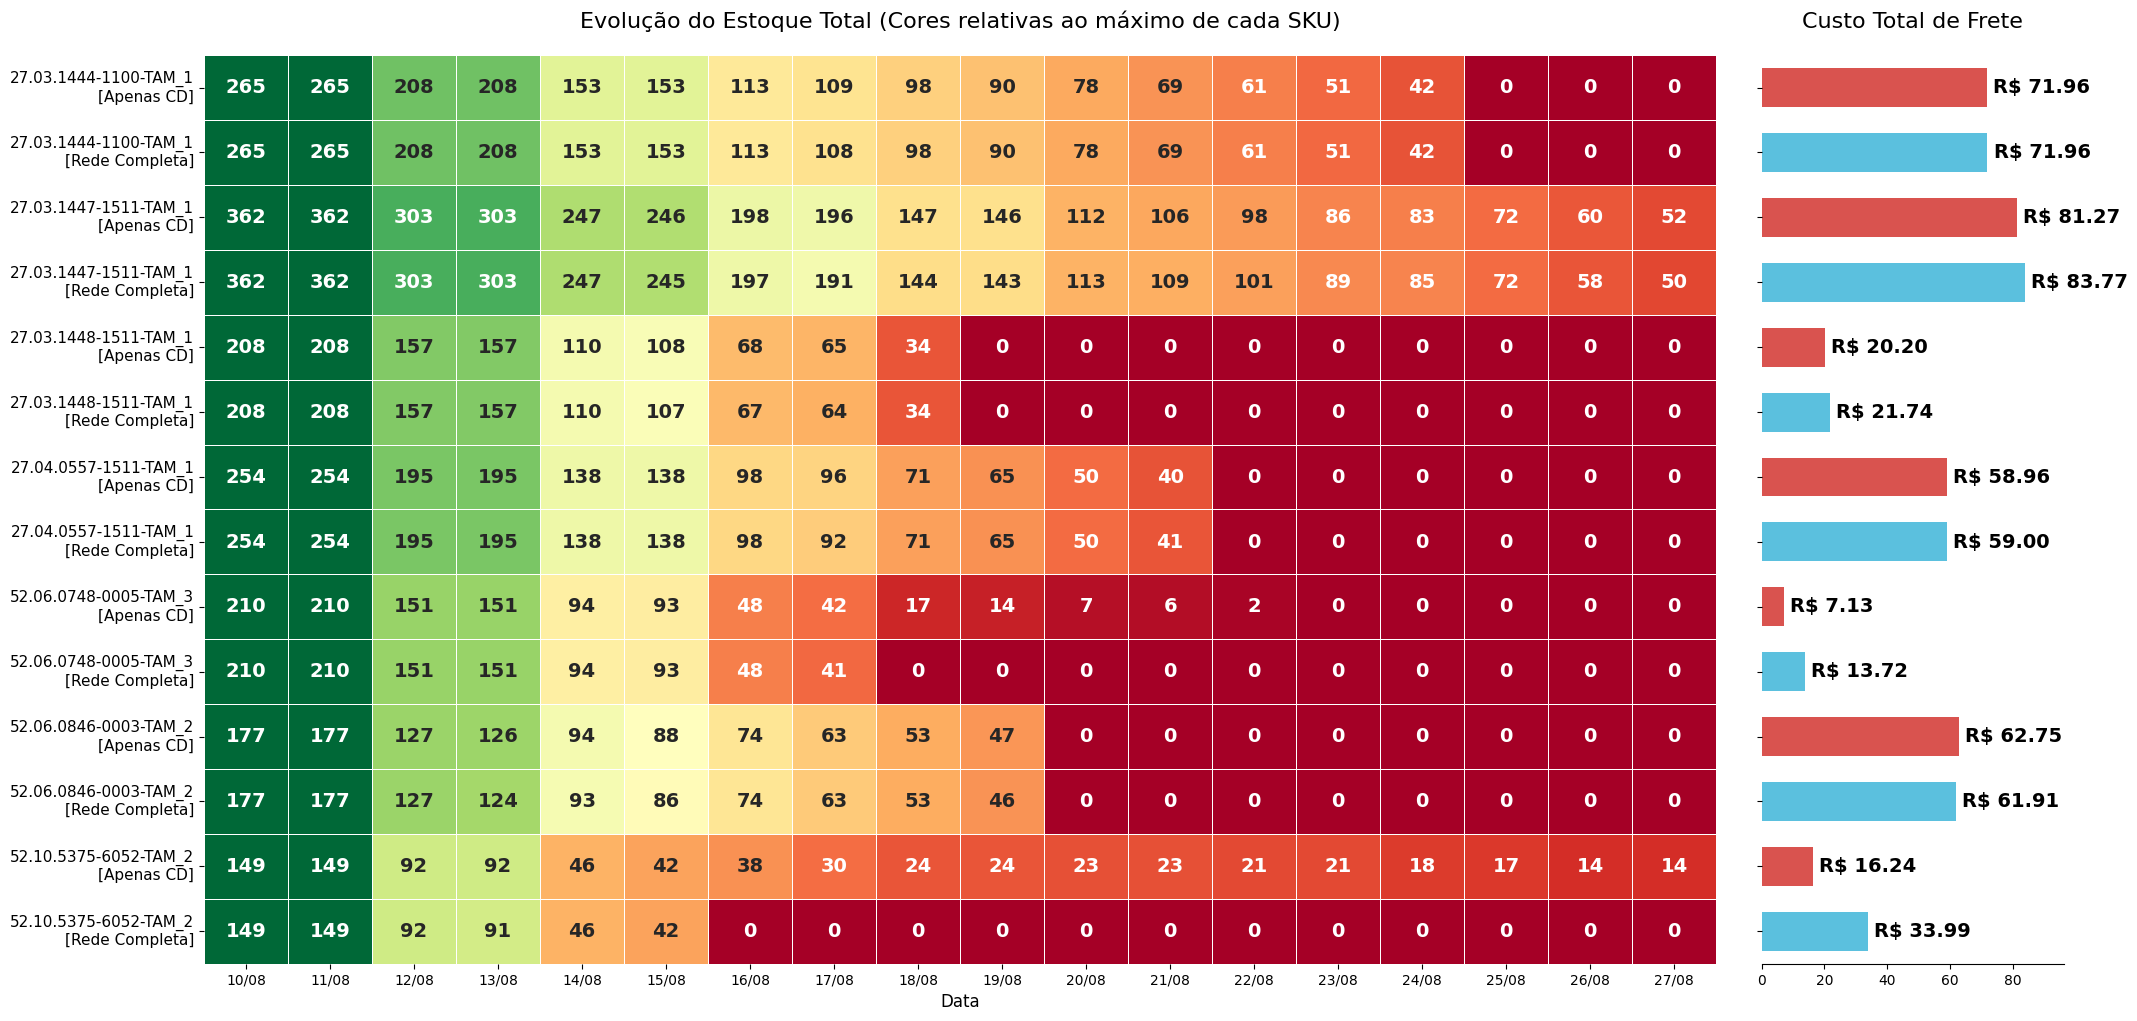


Gráfico corrigido gerado: comparativo_final_corrigido.png


In [6]:

# ==============================================================================
# 1. CONFIGURAÇÃO
# ==============================================================================

LISTA_SKUS = df_resultado['SKU'].unique().tolist()[:10]

DATA_INICIO = '2025-08-10'
MAX_DIAS =17
VELOCIDADE_VENDA = 0.5
PASTA_SAIDA = 'simulacoes_skus'

os.makedirs(PASTA_SAIDA, exist_ok=True)

# ==============================================================================
# 2. EXECUÇÃO EM LOOP (Captura Dupla por SKU)
# ==============================================================================

resultados_estoque = []
resultados_custo = []

print(f"Iniciando bateria para {len(LISTA_SKUS)} SKUs...")

for i, sku in enumerate(LISTA_SKUS):
    clear_output(wait=True)
    print(f"Simulando SKU {i+1}/{len(LISTA_SKUS)}")
    
    # Verificação prévia apenas para FLAG, não para pular
    try:
        estoque_cd_inicial = df_estoque_dia[
            (df_estoque_dia['SKU'] == sku) & 
            (df_estoque_dia['REGULADOR'] != 0)
        ]['REGULADOR'].sum()
    except:
        estoque_cd_inicial = 0 

    if estoque_cd_inicial <= 0:
        print(f"-> SKU {sku} IGNORADO: Sem estoque no CD ({estoque_cd_inicial}).")
        continue
    
    for cenario_nome, is_somente_cd in [("1. Apenas CD", True), ("2. Rede Completa", False)]:
        try:
            # --- MUDANÇA: Roda SEMPRE, mesmo se CD zerado ---
            simulador = SimuladorEstoque(
                df_inicial_db=df_estoque_dia,
                df_distancias=df_distancias,
                sku_alvo=sku,
                data_inicio=DATA_INICIO,
                velocidade_venda=VELOCIDADE_VENDA,
                somente_cd=is_somente_cd
            )
            
            simulador.executar_simulacao(max_dias_simulacao=MAX_DIAS)
            df_final, df_log = simulador.exportar_resultados()

            if not df_final.empty:
                safe_sku = str(sku)
                safe_cenario = cenario_nome.replace('. ', '_').replace(' ', '_')
                nome_arquivo = f"{PASTA_SAIDA}/{safe_sku}__{safe_cenario}.xlsx"
                
                df_final.to_excel(nome_arquivo, index=False)
            
            if not df_final.empty:
                df_analise = df_final.dropna(subset=['DATA']).copy()
                
                # Soma do estoque total da rede
                estoque_diario = df_analise.groupby('DATA')['EST_TOTAL'].sum()
                
                # Normalização de datas
                todos_dias = df_analise['DATA'].unique()
                estoque_diario = estoque_diario.reindex(todos_dias, fill_value=0)
                
                for data, qtd in estoque_diario.items():
                    resultados_estoque.append({
                        'SKU': sku,
                        'CENARIO': cenario_nome,
                        'DATA': pd.to_datetime(data).strftime('%d/%m'),
                        'ESTOQUE_TOTAL': qtd
                    })
            
            custo_total = 0.0
            if not df_log.empty and 'Custo_Frete' in df_log.columns:
                custo_total = df_log['Custo_Frete'].sum()
            
            resultados_custo.append({
                'SKU': sku,
                'CENARIO': cenario_nome,
                'CUSTO_TOTAL': custo_total
            })
            
        except Exception as e:
            print(f"Erro no SKU {sku} ({cenario_nome}): {e}")
            
if resultados_estoque:
    df_heatmap = pd.DataFrame(resultados_estoque)
    df_custos = pd.DataFrame(resultados_custo)
    
    # --- PREPARAÇÃO DA MATRIZ ---
    heatmap_matrix = df_heatmap.pivot(
        index=['SKU', 'CENARIO'],
        columns='DATA',
        values='ESTOQUE_TOTAL'
    )
    
    # Ordenação Cronológica das Colunas
    colunas_ordenadas = sorted(heatmap_matrix.columns, key=lambda x: pd.to_datetime(x, format='%d/%m'))
    heatmap_matrix = heatmap_matrix[colunas_ordenadas]
    
    # --- REINDEX PARA GARANTIR ESTRUTURA ---
    skus_processados = sorted(df_heatmap['SKU'].unique())
    cenarios_esperados = ["1. Apenas CD", "2. Rede Completa"]
    expected_index = pd.MultiIndex.from_product([skus_processados, cenarios_esperados], names=['SKU', 'CENARIO'])
    
    # Preenche vazios com 0
    heatmap_matrix = heatmap_matrix.reindex(expected_index).fillna(0)
    # Garante alinhamento exato para o df_custos
    df_custos = df_custos.set_index(['SKU', 'CENARIO']).reindex(expected_index).fillna(0)
    
    # --- NORMALIZAÇÃO ROBUSTA (SEM LOOP MANUAL) ---
    # 1. Calcula o máximo absoluto de cada SKU (independente do cenário ou dia)
    # Agrupa pelo nível 0 (SKU) e pega o maior valor daquele grupo
    max_por_sku = heatmap_matrix.max(axis=1).groupby(level='SKU').transform('max')
    
    # 2. Evita divisão por zero (troca 0 por 1 apenas para dividir, depois o numerador 0 mantém o resultado 0)
    max_por_sku = max_por_sku.replace(0, 1)
    
    # 3. Divide a matriz inteira pelo vetor de máximos (alinhado pelo índice)
    heatmap_norm = heatmap_matrix.div(max_por_sku, axis=0)
    
    # 4. Segurança final: preenche qualquer NaN residual com 0
    heatmap_norm = heatmap_norm.fillna(0)

    # --- PLOTAGEM ---
    num_linhas = len(heatmap_matrix)
    altura_fig = max(6, num_linhas * 0.7 + 2) 
    
    fig, axes = plt.subplots(1, 2, figsize=(24, altura_fig), sharey=False, gridspec_kw={'width_ratios': [5, 1], 'wspace': 0.05})
    
    # 1. HEATMAP (Esquerda)
    sns.heatmap(
        data=heatmap_norm,      # Cores relativas (0 a 1)
        annot=heatmap_matrix,   # Texto com valor absoluto
        cmap="RdYlGn",          # Vermelho (0) -> Verde (1)
        vmin=0, vmax=1,         # Trava a escala para garantir que 0 seja vermelho
        linewidths=0.5, 
        linecolor='white',
        fmt='.0f',      
        cbar=False,     
        ax=axes[0],
        annot_kws={"size": 14, "weight": "bold"}
    )
    
    axes[0].set_title(f'Evolução do Estoque Total (Cores relativas ao máximo de cada SKU)', fontsize=16, pad=20)
    axes[0].set_xlabel('Data', fontsize=12)
    axes[0].set_ylabel('') 
    
    # Labels Eixo Y formatados
    new_labels = []
    for idx in heatmap_matrix.index:
        sku_clean = str(idx[0])
        cenario_clean = str(idx[1]).replace('1. ', '').replace('2. ', '')
        new_labels.append(f"{sku_clean}\n[{cenario_clean}]")
    axes[0].set_yticklabels(new_labels, rotation=0, va='center', fontsize=11)
    
    # 2. BARRAS DE CUSTO (Direita)
    max_custo = df_custos['CUSTO_TOTAL'].max()
    escala_minima = 1.0
    xmax_plot = max(max_custo * 1.15, escala_minima)
    axes[1].set_xlim(0, xmax_plot)
    
    for i, ((sku, cenario), row) in enumerate(df_custos.iterrows()):
        custo = float(row['CUSTO_TOTAL'])
        y = i + 0.5
        
        # Verifica se linha é vazia para desenhar o aviso "sem estoque no CD"
        estoque_soma = heatmap_matrix.loc[(sku, cenario)].sum()
        
        if ("Apenas CD" in cenario) and (estoque_soma == 0):
            linha_comprimento = max(xmax_plot * 0.12, 0.5)
            axes[1].hlines(y=y, xmin=0, xmax=linha_comprimento, linewidth=4, color='lightgray', alpha=0.95)
            
            texto_x = linha_comprimento * 1.25
            axes[1].text(
                texto_x, y, "sem estoque no CD",
                va='center', ha='left', fontsize=10, color='black', fontweight='bold'
            )
        else:
            cor = '#d9534f' if "Apenas CD" in cenario else '#5bc0de'
            axes[1].barh(y=y, width=custo, color=cor, height=0.6, align='center')
            if custo > 0:
                margem = max(xmax_plot * 0.02, 0.5)
                axes[1].text(custo + margem, y, f"R$ {custo:,.2f}", va='center', fontsize=14, color='black', fontweight='bold')
    
    # Ajustes finais Eixo Y da direita
    axes[1].set_ylim(num_linhas, 0)
    axes[1].set_yticks(np.arange(num_linhas) + 0.5)
    axes[1].set_yticklabels([])
    axes[1].set_title('Custo Total de Frete', fontsize=16, pad=20)
    
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['left'].set_visible(False)
    
    plt.tight_layout()
    nome_img = 'comparativo_final_corrigido.png'
    plt.savefig(nome_img, dpi=150, bbox_inches='tight', pad_inches=0.5)
    plt.show()
    
    print(f"\nGráfico corrigido gerado: {nome_img}")

else:
    print("Nenhum dado gerado para visualização.")


In [7]:
def calcular_esgotamento_skus(lista_skus, df_estoque_dia, df_distancias, data_inicio, max_dias, velocidade_venda):
    """
    Simula cenários para uma lista de SKUs e conta qual método esgota o estoque primeiro.
    
    Retorna:
    - dict com contagens: {'apenas_cd_vence': int, 'rede_completa_vence': int, 'empates': int}
    - DataFrame detalhado com os dias de esgotamento por SKU.
    """
    
    count_apenas_cd_primeiro = 0
    count_rede_completa_primeiro = 0
    count_empates = 0
    
    detalhes = []
    
    print(f"Iniciando análise de esgotamento para {len(lista_skus)} SKUs...")
    
    for i, sku in enumerate(lista_skus):
        clear_output(wait=True)
        print(f"Analisando Esgotamento SKU {i+1}/{len(lista_skus)}: {sku}")
        
        # --- Verificação de Elegibilidade (Estoque no CD) ---
        try:
            estoque_cd_inicial = df_estoque_dia[
                (df_estoque_dia['SKU'] == sku) & 
                (df_estoque_dia['FILIAL'] == 'CENTRO DE DISTRIBUICAO')
            ]['REGULADOR'].sum()
        except:
            estoque_cd_inicial = 0 

        if estoque_cd_inicial <= 0:
            continue
            
        # Dicionário para guardar o dia que zerou em cada cenário
        dias_esgotamento = {}
        
        for cenario_nome, is_somente_cd in [("apenas_cd", True), ("rede_completa", False)]:
            try:
                simulador = SimuladorEstoque(
                    df_inicial_db=df_estoque_dia,
                    df_distancias=df_distancias,
                    sku_alvo=sku,
                    data_inicio=data_inicio,
                    velocidade_venda=velocidade_venda,
                    somente_cd=is_somente_cd
                )
                
                simulador.executar_simulacao(max_dias_simulacao=max_dias)
                df_final, _ = simulador.exportar_resultados()
                
                dia_zero = None
                
                if not df_final.empty:
                    df_analise = df_final.dropna(subset=['DATA']).copy()
                    
                    # Agrupa estoque total por dia
                    estoque_diario = df_analise.groupby('DATA')['EST_TOTAL'].sum()
                    
                    # Procura o primeiro dia onde estoque <= 0
                    dias_com_estoque_zero = estoque_diario[estoque_diario <= 0].index
                    
                    if not dias_com_estoque_zero.empty:
                        # Pega a primeira data de esgotamento
                        dia_zero = dias_com_estoque_zero.min()
                    else:
                        # Se nunca zerou, definimos como infinito (ou max_dias + 1) para comparação
                        dia_zero = pd.Timestamp.max
                
                dias_esgotamento[cenario_nome] = dia_zero
                
            except Exception as e:
                print(f"Erro no SKU {sku}: {e}")
                dias_esgotamento[cenario_nome] = pd.Timestamp.max
        
        # --- Comparação ---
        dia_cd = dias_esgotamento.get('apenas_cd', pd.Timestamp.max)
        dia_rede = dias_esgotamento.get('rede_completa', pd.Timestamp.max)
        
        vencedor = "Empate/Nenhum"
        
        if dia_cd < dia_rede:
            # Apenas CD acabou antes (pior disponibilidade)
            count_apenas_cd_primeiro += 1
            vencedor = "Apenas CD acabou antes"
        elif dia_rede < dia_cd:
            # Rede Completa acabou antes (vendeu mais rápido ou transferiu mal)
            count_rede_completa_primeiro += 1
            vencedor = "Rede Completa acabou antes"
        else:
            count_empates += 1
            
        detalhes.append({
            'SKU': sku,
            'Dia_Fim_CD': dia_cd if dia_cd != pd.Timestamp.max else "Não Esgotou",
            'Dia_Fim_Rede': dia_rede if dia_rede != pd.Timestamp.max else "Não Esgotou",
            'Resultado': vencedor
        })

    print("\n--- Análise Concluída ---")
    
    resultados = {
        'Apenas CD Zerou Primeiro': count_apenas_cd_primeiro,
        'Rede Completa Zerou Primeiro': count_rede_completa_primeiro,
        'Empates (ou nenhum zerou)': count_empates
    }
    
    return resultados, pd.DataFrame(detalhes)


# ==============================================================================
# EXEMPLO DE USO
# ==============================================================================

# Definição dos parâmetros (iguais ao seu script)
LISTA_SKUS_TESTE = df_resultado['SKU'].unique().tolist()[:100] # Ajuste conforme necessário
DATA_INICIO = '2025-08-10'
MAX_DIAS = 17
VELOCIDADE_VENDA = 0.5

# Chamada da função
placar, df_detalhes = calcular_esgotamento_skus(
    lista_skus=LISTA_SKUS_TESTE,
    df_estoque_dia=df_estoque_dia,
    df_distancias=df_distancias,
    data_inicio=DATA_INICIO,
    max_dias=MAX_DIAS,
    velocidade_venda=VELOCIDADE_VENDA
)

# Exibição dos Resultados
print("\n--- PLACAR FINAL (Quem esgota primeiro?) ---")
print(f"Apenas CD (Pior Disponibilidade): {placar['Apenas CD Zerou Primeiro']}")
print(f"Rede Completa (Maior Giro):       {placar['Rede Completa Zerou Primeiro']}")
print(f"Empates:                          {placar['Empates (ou nenhum zerou)']}")

# Mostra tabela detalhada
# display(df_detalhes)

Analisando Esgotamento SKU 100/100: 52.39.0399-0003-TAM_2

--- Análise Concluída ---

--- PLACAR FINAL (Quem esgota primeiro?) ---
Apenas CD (Pior Disponibilidade): 0
Rede Completa (Maior Giro):       0
Empates:                          0


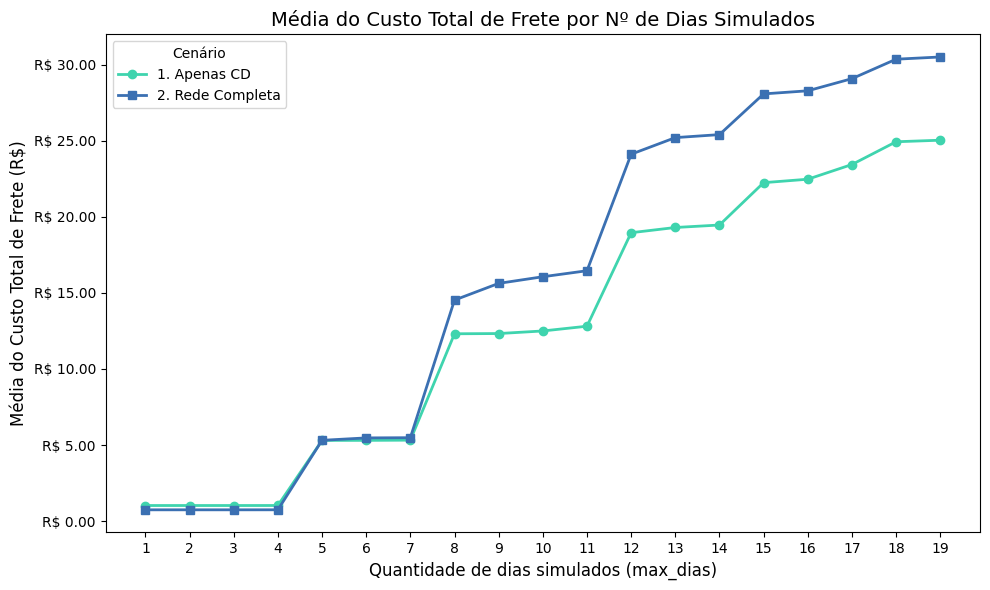


Gráfico salvo em: simulacoes_skus_mean\media_custo_frete_por_dias.png
Resumo salvo em: simulacoes_skus_mean\resumo_media_custos_por_dias.csv

Resumo (MEAN_CUSTO, STD_CUSTO, N_SKUS):
 MAX_DIAS          CENARIO  MEAN_CUSTO  STD_CUSTO  N_SKUS
        1     1. Apenas CD    1.031375   2.342657      30
        1 2. Rede Completa    0.748931   1.615279      30
        2     1. Apenas CD    1.031375   2.342657      30
        2 2. Rede Completa    0.748931   1.615279      30
        3     1. Apenas CD    1.031375   2.342657      30
        3 2. Rede Completa    0.748931   1.615279      30
        4     1. Apenas CD    1.032474   2.342653      30
        4 2. Rede Completa    0.750031   1.615465      30
        5     1. Apenas CD    5.308158   7.992968      30
        5 2. Rede Completa    5.314374   7.820328      30
        6     1. Apenas CD    5.311141   8.001900      30
        6 2. Rede Completa    5.473245   8.148120      30
        7     1. Apenas CD    5.324653   8.016323      30
     

In [8]:
from matplotlib.ticker import FuncFormatter


# ------------------------------------------------------------------
# Ajustes / parâmetros (mantém sua lógica)
# ------------------------------------------------------------------
LISTA_SKUS = df_resultado['SKU'].unique().tolist()[:30]  # mesma seleção que você usa
DATA_INICIO = '2025-08-10'
VELOCIDADE_VENDA = 0.3
PASTA_SAIDA = 'simulacoes_skus_mean'
os.makedirs(PASTA_SAIDA, exist_ok=True)

CENARIOS = [("1. Apenas CD", True), ("2. Rede Completa", False)]
DIAS_A_TESTAR = list(range(1, 20))  # 1 a 5

# ------------------------------------------------------------------
# Estruturas para acumular resultados
# ------------------------------------------------------------------
# Will store rows: {'MAX_DIAS': int, 'SKU': sku, 'CENARIO': nome, 'CUSTO_TOTAL': float}
tabela_custos = []

print(f"Iniciando simulações média de custo para {len(LISTA_SKUS)} SKUs e {len(DIAS_A_TESTAR)} valores de dias...")

for max_dias in DIAS_A_TESTAR:
    print(f"\n--- MAX_DIAS = {max_dias} ---")
    for i, sku in enumerate(LISTA_SKUS):
        clear_output(wait=True)
        # Exibe progresso simples
        if (i % 10) == 0:
            print(f"  SKU {i+1}/{len(LISTA_SKUS)}: {sku}")
        # Verificação prévia como no seu código (FLAG)
        try:
            estoque_cd_inicial = df_estoque_dia[
                (df_estoque_dia['SKU'] == sku) & 
                (df_estoque_dia['REGULADOR'] != 0)
            ]['REGULADOR'].sum()
        except Exception:
            estoque_cd_inicial = 0

        if estoque_cd_inicial <= 0:
            # Mantive comportamento de "ignorar" (apenas para o caso "Apenas CD" faz sentido)
            # Ainda assim, registramos custo = 0 para ambos cenários (ou você pode pular)
            for cenario_nome, is_somente_cd in CENARIOS:
                tabela_custos.append({
                    'MAX_DIAS': max_dias,
                    'SKU': sku,
                    'CENARIO': cenario_nome,
                    'CUSTO_TOTAL': 0.0
                })
            continue

        for cenario_nome, is_somente_cd in CENARIOS:
            try:
                simulador = SimuladorEstoque(
                    df_inicial_db=df_estoque_dia,
                    df_distancias=df_distancias,
                    sku_alvo=sku,
                    data_inicio=DATA_INICIO,
                    velocidade_venda=VELOCIDADE_VENDA,
                    somente_cd=is_somente_cd
                )
                simulador.executar_simulacao(max_dias_simulacao=max_dias)
                df_final, df_log = simulador.exportar_resultados()

                custo_total = 0.0
                if not df_log.empty and 'Custo_Frete' in df_log.columns:
                    custo_total = df_log['Custo_Frete'].sum()

                tabela_custos.append({
                    'MAX_DIAS': max_dias,
                    'SKU': sku,
                    'CENARIO': cenario_nome,
                    'CUSTO_TOTAL': float(custo_total)
                })

            except Exception as e:
                # Em caso de erro no SKU/cenario, registra NaN para não contaminar a média
                print(f"Erro SKU {sku} ({cenario_nome}) em max_dias={max_dias}: {e}")
                tabela_custos.append({
                    'MAX_DIAS': max_dias,
                    'SKU': sku,
                    'CENARIO': cenario_nome,
                    'CUSTO_TOTAL': np.nan
                })

# ------------------------------------------------------------------
# Agrega médias por MAX_DIAS x CENARIO
# ------------------------------------------------------------------
df_custos_all = pd.DataFrame(tabela_custos)

# Calcula média, desvio e contagem válidos (ignora NaN)
df_summary = df_custos_all.groupby(['MAX_DIAS', 'CENARIO'])['CUSTO_TOTAL'].agg(
    MEAN_CUSTO = lambda s: float(np.nanmean(s.values)),
    STD_CUSTO  = lambda s: float(np.nanstd(s.values, ddof=0)),
    N_SKUS     = lambda s: int(np.sum(~np.isnan(s.values)))
).reset_index()

# Pivot para facilitar plotagem (linhas por cenário)
pivot_mean = df_summary.pivot(index='MAX_DIAS', columns='CENARIO', values='MEAN_CUSTO')

# ------------------------------------------------------------------
# Plotagem: linha com média por cenário
# ------------------------------------------------------------------
plt.figure(figsize=(10,6))
markers = {'1. Apenas CD': 'o', '2. Rede Completa': 's'}

for cenario in pivot_mean.columns:
    y = pivot_mean[cenario].values
    plt.plot(pivot_mean.index, y, marker=markers.get(cenario, 'o'), linewidth=2, label=cenario)

plt.title('Média do Custo Total de Frete por Nº de Dias Simulados', fontsize=14)
plt.xlabel('Quantidade de dias simulados (max_dias)', fontsize=12)
plt.ylabel('Média do Custo Total de Frete (R$)', fontsize=12)
plt.xticks(pivot_mean.index)
# plt.grid(axis='y', alpha=0.25)
# coloração de cada linha:
colors = {'1. Apenas CD': '#3FD4AE', '2. Rede Completa': '#3B70B2'}
for line in plt.gca().get_lines():
    label = line.get_label()
    if label in colors:
        line.set_color(colors[label])
        
plt.legend(title='Cenário')

# Formatação de ticks em real (R$)
def real_formatter(x, pos):
    # formata 0 como "R$ 0" e valores com separador de milhar
    try:
        return f"R$ {x:,.2f}"
    except:
        return f"R$ {x}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(real_formatter))

plt.tight_layout()
nome_img = os.path.join(PASTA_SAIDA, 'media_custo_frete_por_dias.png')
plt.savefig(nome_img, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGráfico salvo em: {nome_img}")

# ------------------------------------------------------------------
# Salva também um CSV resumo com as médias para inspeção
# ------------------------------------------------------------------
csv_out = os.path.join(PASTA_SAIDA, 'resumo_media_custos_por_dias.csv')
df_summary.to_csv(csv_out, index=False)
print(f"Resumo salvo em: {csv_out}")

# Opcional: mostra a tabela resumo no console
print("\nResumo (MEAN_CUSTO, STD_CUSTO, N_SKUS):")
print(df_summary.sort_values(['MAX_DIAS','CENARIO']).to_string(index=False))


Simulando 1000 de 1000:
--- Simulação: 25.34.2321-10057-TAM_3 (20 dias) ---


C:\Users\Leonardo Verissimo\AppData\Local\Temp\ipykernel_18068\3192049294.py:556: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_estados_final = pd.concat(lista_com_espacos, ignore_index=True)


Critério de parada atingido no dia 2: não há mais SKUs com excesso. Simulação interrompida (rodou 2 dia(s)).
--- Simulação Concluída ---
--- Simulação: 25.34.2321-10057-TAM_3 (20 dias) ---
Critério de parada atingido no dia 1: não há mais SKUs com excesso. Simulação interrompida (rodou 1 dia(s)).
--- Simulação Concluída ---


C:\Users\Leonardo Verissimo\AppData\Local\Temp\ipykernel_18068\3192049294.py:556: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_estados_final = pd.concat(lista_com_espacos, ignore_index=True)


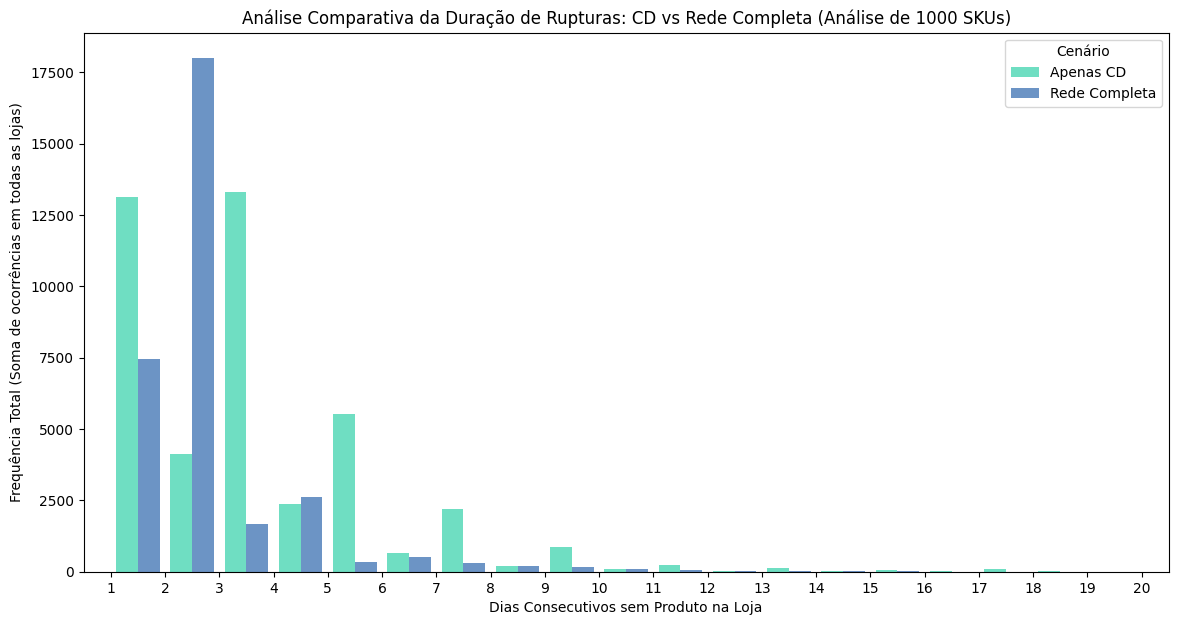


=== Resumo Geral (Média de todos os SKUs) ===
                 count      mean  50%   max
Cenário                                    
Apenas CD      43035.0  3.152945  3.0  19.0
Rede Completa  31503.0  2.277624  2.0  17.0


In [9]:
# --- 1. CONFIGURAÇÃO ---
LISTA_SKUS = df_estoque_dia['SKU'].unique()[:1000]
DATA_INI = '2025-08-10'
MAX_DIAS = 20
VELOCIDADE = 0.5

lista_dados_finais = []

print(f"Iniciando bateria de simulações para {len(LISTA_SKUS)} SKUs...")

for i, sku in enumerate(LISTA_SKUS):
    clear_output(wait=True)
    # Progresso tanto de tantos
    print(f"Simulando {i+1} de {len(LISTA_SKUS)}:")
    
    # Para cada SKU, roda os dois cenários (Apenas CD e Rede Completa)
    for nome_cenario, usar_apenas_cd in [('Apenas CD', True), ('Rede Completa', False)]:
        try:
            sim = SimuladorEstoque(
                df_inicial_db=df_estoque_dia, 
                df_distancias=df_distancias,
                sku_alvo=sku, 
                data_inicio=DATA_INI, 
                velocidade_venda=VELOCIDADE,
                somente_cd=usar_apenas_cd
            )
            
            sim.executar_simulacao(max_dias_simulacao=MAX_DIAS)
            df_resultado, _ = sim.exportar_resultados()

            # remove as linhas em branco
            df = df_resultado.dropna(subset=['DATA']).copy()
            df = df[df['FILIAL'] != 'CENTRO DE DISTRIBUICAO'].sort_values(by=['FILIAL', 'DATA'])
            if df.empty: continue

            # 2. Identifica blocos consecutivos de estoque
            df['sem_estoque'] = df['EST_DISP'] == 0
            # shift compara com o valor anterior para detectar mudanças
            df['grupo'] = (df['sem_estoque'] != df['sem_estoque'].shift()).cumsum()
            
            # 3. Filtra apenas os grupos onde REALMENTE estava sem estoque e conta o tamanho
            df_ruptura = df[df['sem_estoque']]
            contagem = df_ruptura.groupby(['FILIAL', 'grupo']).size()
            
            if not contagem.empty:
                temp_df = pd.DataFrame({
                    'SKU': sku,
                    'Duração (Dias)': contagem.values,
                    'Cenário': nome_cenario
                })
                lista_dados_finais.append(temp_df)
                
        except Exception as e:
            print(f"   Erro no cenário {nome_cenario}: {e}")

# --- 3. PLOTAGEM AGREGADA ---

if lista_dados_finais:
    df_grafico = pd.concat(lista_dados_finais)
    plt.figure(figsize=(14, 7))
    
    # Histograma Comparativo
    sns.histplot(
        data=df_grafico,
        x='Duração (Dias)',
        hue='Cenário',
        multiple='dodge', 
        binwidth=1,
        shrink=0.8,
        palette=['#3FD4AE', '#3B70B2'],
        edgecolor=None,
        linewidth=0 
    )
    
    qtd_skus = df_grafico['SKU'].nunique()
    plt.title(f"Análise Comparativa da Duração de Rupturas: CD vs Rede Completa (Análise de {qtd_skus} SKUs)")
    plt.xlabel("Dias Consecutivos sem Produto na Loja")
    plt.ylabel("Frequência Total (Soma de ocorrências em todas as lojas)")
    
    max_dias = int(df_grafico['Duração (Dias)'].max())
    plt.xticks(range(1, max_dias + 2))
    plt.xlim(0.5, max_dias + 1.5)
    
    # plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Resumo Estatístico
    print("\n=== Resumo Geral (Média de todos os SKUs) ===")
    print(df_grafico.groupby('Cenário')['Duração (Dias)'].describe()[['count', 'mean', '50%', 'max']])

else:
    print("Nenhum evento de ruptura física (Estoque=0) foi detectado para esses SKUs.")